In [33]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [34]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def tokenize_and_remove_stopwords(text):
    tokens = tokenizer.morphs(text)
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

def load_data(train_data, test_data, num_words):
    train_data.drop_duplicates(inplace=True)
    test_data.drop_duplicates(inplace=True)
    train_data.dropna(how='any',inplace=True)
    test_data.dropna(how='any', inplace=True)
    train_data.reset_index(inplace=True, drop=True)
    test_data.reset_index(inplace=True, drop=True)

    token_list=[]
    for sentence in train_data['document']:
        token_list.extend(tokenize_and_remove_stopwords(sentence))

    word_counts = Counter(token_list)
    word_to_index = {word: idx + 3 for idx, (word, _) in enumerate(word_counts.most_common(num_words-3))}
    word_to_index['<PAD>'] = 0
    word_to_index['<UNK>'] = 1
    word_to_index['<BOS>'] = 2

    train_data['tokens']=train_data['document'].apply(tokenize_and_remove_stopwords)
    test_data['tokens']=test_data['document'].apply(tokenize_and_remove_stopwords)
    train_data['sequence']=train_data['tokens'].apply(lambda x : [word_to_index['<BOS>']]+[word_to_index.get(i,word_to_index['<UNK>']) for i in x])
    test_data['sequence']=test_data['tokens'].apply(lambda x : [word_to_index['<BOS>']]+[word_to_index.get(i,word_to_index['<UNK>']) for i in x])
    
    return list(train_data['sequence']), np.array(list(train_data['label'])), list(test_data['sequence']), np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data,20000)

In [27]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in tokenizer.morphs(sentence)]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [28]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [39]:
import tensorflow as tf
import os

In [42]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.65940637625505
문장길이 최대 :  117
문장길이 표준편차 :  12.859527414389605
pad_sequences maxlen :  42
전체 문장의 0.9358074322972919%가 maxlen 설정값 이내에 포함됩니다. 


In [43]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=42)
x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=42)

In [46]:
vocab_size = len(word_to_index) # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 40   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 40)          800000    
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 800,337
Trainable params: 800,337
Non-trainable params: 0
_________________________________________________________________


In [47]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 40   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          800000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          4496      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [48]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 40  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 40)          800000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1568      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 801,649
Trainable params: 801,649
Non-trainable params: 0
_________________________________________________________________


In [50]:
len(x_train)

149995

In [58]:
idx=round(0.2*len(x_train))
          
x_val = x_train[:idx]   
y_val = y_train[:idx]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[idx:]  
partial_y_train = y_train[idx:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(119996, 42)
(119996,)


In [59]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 2s 4ms/step - loss: 0.5579 - accuracy: 0.7520 - val_loss: 0.3947 - val_accuracy: 0.8330
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3469 - accuracy: 0.8550 - val_loss: 0.3416 - val_accuracy: 0.8499
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2915 - accuracy: 0.8807 - val_loss: 0.3356 - val_accuracy: 0.8549
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2552 - accuracy: 0.8980 - val_loss: 0.3416 - val_accuracy: 0.8548
Epoch 5/20
235/235 [==============================] - 1s 3ms/step - loss: 0.2249 - accuracy: 0.9120 - val_loss: 0.3528 - val_accuracy: 0.8543
Epoch 6/20
235/235 [==============================] - 1s 3ms/step - loss: 0.1983 - accuracy: 0.9248 - val_loss: 0.3714 - val_accuracy: 0.8517
Epoch 7/20
235/235 [==============================] - 1s 3ms/step - loss: 0.1743 - accuracy: 0.9353 - val_loss: 0.3908 - val_accuracy: 0.8482
Epoch 

In [60]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 4s 6ms/step - loss: 0.4790 - accuracy: 0.7613 - val_loss: 0.3616 - val_accuracy: 0.8388
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.3199 - accuracy: 0.8634 - val_loss: 0.3491 - val_accuracy: 0.8435
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2624 - accuracy: 0.8928 - val_loss: 0.3581 - val_accuracy: 0.8447
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.2051 - accuracy: 0.9197 - val_loss: 0.3989 - val_accuracy: 0.8391
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1537 - accuracy: 0.9434 - val_loss: 0.4449 - val_accuracy: 0.8353
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1139 - accuracy: 0.9598 - val_loss: 0.4976 - val_accuracy: 0.8321
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0868 - accuracy: 0.9691 - val_loss: 0.5558 - val_accuracy: 0.8270
Epoch 

In [61]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 3s 7ms/step - loss: 0.4938 - accuracy: 0.7714 - val_loss: 0.3591 - val_accuracy: 0.8471
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.3285 - accuracy: 0.8641 - val_loss: 0.3430 - val_accuracy: 0.8538
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2970 - accuracy: 0.8791 - val_loss: 0.3451 - val_accuracy: 0.8535
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2768 - accuracy: 0.8892 - val_loss: 0.3509 - val_accuracy: 0.8522
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2623 - accuracy: 0.8959 - val_loss: 0.3612 - val_accuracy: 0.8495
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2471 - accuracy: 0.9027 - val_loss: 0.3766 - val_accuracy: 0.8482
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.2330 - accuracy: 0.9083 - val_loss: 0.3856 - val_accuracy: 0.8485
Epoch 

In [62]:
history_dict = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

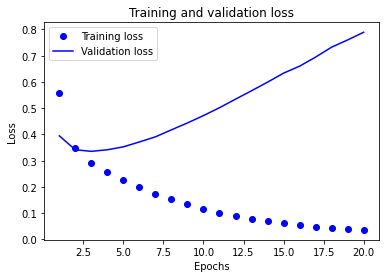

In [63]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

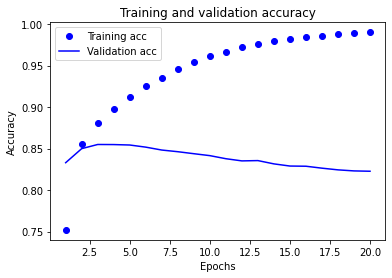

In [64]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]

In [67]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [68]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [70]:
word_vectors.similar_by_word("재밌") # 형편없다

[('콜린스', 0.6878893375396729),
 ('최정원', 0.6255038380622864),
 ('두렵', 0.620094895362854),
 ('..!', 0.6183009743690491),
 ('상하이', 0.6150099039077759),
 ('예쁜', 0.6108370423316956),
 ('잖', 0.6094949245452881),
 ('욤', 0.6094669103622437),
 ('어머니', 0.6081631183624268),
 ('왔었', 0.598190188407898)]

In [73]:
model_path = os.getenv('HOME')+'/data/word2vec_ko.model'

In [74]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load(model_path)


In [76]:
vector = word_vectors.wv["끝"]

In [80]:
vector.shape

(100,)

In [84]:
word_vectors.wv.most_similar('재밌') # 훌룡하다.

[('재미있', 0.905171275138855),
 ('멋있', 0.8684316277503967),
 ('웃기', 0.8312839269638062),
 ('예쁘', 0.8087937235832214),
 ('슬프', 0.7751518487930298),
 ('무섭', 0.7676399350166321),
 ('재미없', 0.7673381567001343),
 ('멋지', 0.7514932155609131),
 ('신나', 0.7510867714881897),
 ('서툴', 0.7421588897705078)]

In [86]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(3,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [88]:
embedding_matrix.shape

(20000, 100)

In [119]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100 # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=42, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 42, 100)           2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 2,085,521
Trainable params: 2,085,521
Non-trainable params: 0
_________________________________________________________________


In [120]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',             # 저장 파일명
    monitor='val_loss',          # validation loss가 가장 좋은 모델만 저장
    save_best_only=True,         # 가장 좋은 것만 저장
    save_weights_only=False      # 전체 모델 저장 (구조 + 가중치)
)
              
epochs=40  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/40
235/235 [==============================] - 6s 14ms/step - loss: 0.4881 - accuracy: 0.7591 - val_loss: 0.3935 - val_accuracy: 0.8252
Epoch 2/40
235/235 [==============================] - 3s 12ms/step - loss: 0.3555 - accuracy: 0.8445 - val_loss: 0.3466 - val_accuracy: 0.8478
Epoch 3/40
235/235 [==============================] - 3s 12ms/step - loss: 0.3068 - accuracy: 0.8694 - val_loss: 0.3304 - val_accuracy: 0.8561
Epoch 4/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2731 - accuracy: 0.8864 - val_loss: 0.3252 - val_accuracy: 0.8611
Epoch 5/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2486 - accuracy: 0.8992 - val_loss: 0.3305 - val_accuracy: 0.8621
Epoch 6/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2252 - accuracy: 0.9099 - val_loss: 0.3356 - val_accuracy: 0.8615
Epoch 7/40
235/235 [==============================] - 3s 12ms/step - loss: 0.2050 - accuracy: 0.9200 - val_loss: 0.3504 - val_accuracy: 0.8605

In [121]:
model = tf.keras.models.load_model('best_model.h5')

In [122]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1563/1563 - 5s - loss: 0.3344 - accuracy: 0.8563
[0.3344214856624603, 0.8562913537025452]
